In [11]:
import numpy
# Cell 1: Import necessary libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from typing import Tuple


In [162]:
class ActuatorDataset(Dataset):
    def __init__(self, csv_path: str,
                 history_steps: int = 3,
                 target_freq: int = 100):
        """
        Args:
            csv_path: Path to CSV file
            history_steps: Number of history steps (paper uses 3: t, t-0.01, t-0.02)
        """
        self.raw_df = pd.read_csv(csv_path)
        self.target_dt = 1 / target_freq

        self.measured_dts = np.diff(self.raw_df["time"].values)
        self.raw_dt= np.mean(self.measured_dts)
        current_freq = 1 / self.raw_dt
        downsample_factor = int( current_freq/ target_freq)

        # downsample the data
        self.df = self.raw_df[::downsample_factor].reset_index(drop=True)
        measured_dts = np.diff(self.df["time"].values)
        mean_dt = np.mean(measured_dts)


        self.data = None  # Will hold processed DataFrame
        self.history_steps = history_steps
        self.scaler_params = {}  # Store normalization parameters
        self.features = None
        self.targets = None
        self.time = None

    def get_raw_data(self) -> pd.DataFrame:
        return self.raw_df
    
    def get_raw_dt(self) -> float:
        return self.raw_dt
    def get_df(self) -> pd.DataFrame:
        return self.df
    def print_info(self) -> None:
        # Display basic information about the dataset
        print("Dataset Info:")
        print(self.df.info())
        print("\nFirst few rows:")
        print(self.df.head())
        print("\nBasic statistics:")
        print(self.df.describe())

        # Calculate and display timestep statistics
        dt = np.diff(self.df['time'])
        print("\nTimestep statistics:")
        print(f"Mean dt: {dt.mean():.6f}s")
        print(f"Std dt: {dt.std():.6f}s")
        print(f"Min dt: {dt.min():.6f}s")
        print(f"Max dt: {dt.max():.6f}s")
    
    def preprocess_data(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:

        self.df["position_error"] = self.df["target_position"] - self.df["position"]
        time = []
        features = []
        targets = []
        

        for i in range(len(self.df) - self.history_steps + 1):
            window = self.df.iloc[i:i + self.history_steps]
            # Check if window is valid
            time_diffs = np.diff(window["time"].values)
            
            if np.any(abs(time_diffs - self.target_dt) > 0.002) :
                continue
            # extract features and targets
            pos_errors = window["position_error"].values[::-1]
            velocities = window["velocity"].values[::-1]
            feature = np.concatenate([pos_errors, velocities])
            target = window["torque"].values[-1]
            features.append(feature)
            targets.append(target)
            time.append(window["time"].values[-1])
        
        self.features = np.array(features)
        self.targets = np.array(targets) 
        self.time = np.array(time)
        return self.features, self.targets, self.time
    
    def normalize_data(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """Normalize features"""
        pos_errors = self.features[:, :self.history_steps]
        velocities = self.features[:, self.history_steps:]
        

        # store normalization parameters
        self.scaler_params = {
            "time_mean": self.time.mean(),
            "time_std": self.time.std(),
            "pos_error_mean": pos_errors.mean(),
            "pos_error_std": pos_errors.std(),
            "pos_error_max": pos_errors.max(),
            "pos_error_min": pos_errors.min(),
            "vel_mean": velocities.mean(),
            "vel_std": velocities.std(),
            "vel_max": velocities.max(),
            "vel_min": velocities.min(),
            "torque_mean": self.targets.mean(),
            "torque_std": self.targets.std(),
            "torque_max": self.targets.max(),
            "torque_min": self.targets.min()
        }

        # Standardize data (z-score normalization)
        pos_errors_norm = (pos_errors - self.scaler_params['pos_error_mean']) / self.scaler_params['pos_error_std']
        velocities_norm = (velocities - self.scaler_params['vel_mean']) / self.scaler_params['vel_std']
        targets_norm = (self.targets - self.scaler_params['torque_mean']) / self.scaler_params['torque_std']
        time_norm = (self.time - self.scaler_params['time_mean']) / self.scaler_params['time_std']

        self.features = np.concatenate([pos_errors_norm, velocities_norm], axis=1)
        self.targets = targets_norm
        print(f"Features shape: {self.features.shape}, Targets shape: {self.targets.shape}")
        return self.features, self.targets, self.time
    
    def save_prepocessed_data(self, file_path: str) -> None:
        headers = ["pos_error_t-0.000", "pos_error_t-0.010", "pos_error_t-0.020","velocity_t-0.000","velocity_t-0.010" ,"velocity_t-0.020","torque"]
        processed_data: np.array = np.column_stack([self.features, self.targets])
        df_processed_data = pd.DataFrame(processed_data)
        df_processed_data.to_csv(file_path, index=False, header=headers, float_format='%.6f')
    
    def __len__(self):
        return len(self.features)
    def __getitem__(self, index : int)-> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        return self.features[index], self.targets[index], self.time[index]
    

        
        

We separate the dataset into 100hz and 500hz 100hz per the paper.' suggested frequency.
and 500hz for the measure frequency. That we used. 

In [163]:
print("100hz dataset")
dataset_100 = ActuatorDataset("../data/data_full_200125_1914.csv")
print("500hz dataset")
dataset_500 = ActuatorDataset("../data/data_full_200125_1914.csv", target_freq=500)

100hz dataset
500hz dataset


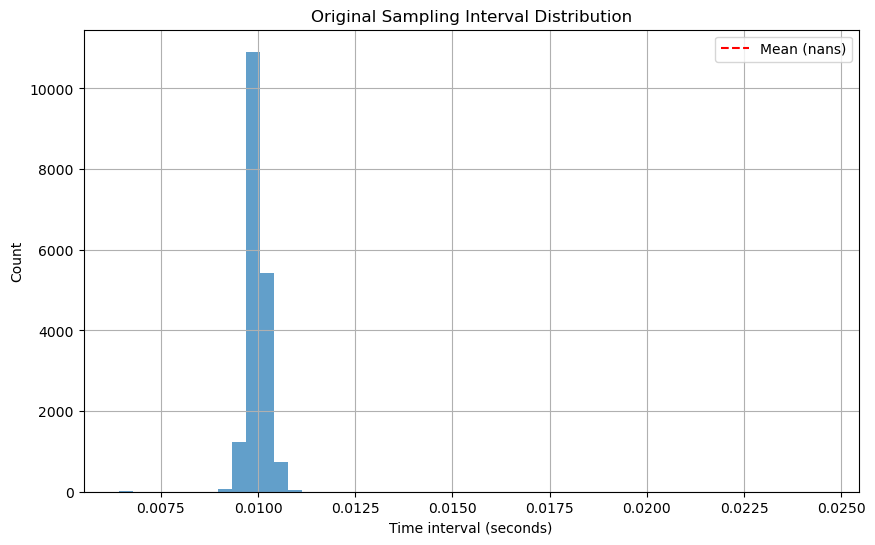

In [164]:
# Display basic information about the time diff, to see if the data is sampled at a constant rate
dt_100 = dataset_100.get_df()["time"].diff().values
plt.figure(figsize=(10, 6))
plt.hist(dt_100, bins=50, alpha=0.7)
plt.axvline(np.mean(dt_100), color='r', linestyle='--', label=f'Mean ({np.mean(dt_100):.4f}s)')
plt.title('Original Sampling Interval Distribution')
plt.xlabel('Time interval (seconds)')
plt.ylabel('Count')
plt.grid(True)
plt.legend()
plt.show()

Possibly, the fact the data is not sample at a constant rate might hurts us. H 
In descriptive statistics, the interquartile range (IQR) is a measure of statistical dispersion, which is the spread of the data.[1] The IQR may also be called the midspread, middle 50%, fourth spread, or H‑spread. It is defined as the difference between the 75th and 25th percentiles of the data.[2][3][4] To calculate the IQR, the data set is divided into quartiles, or four rank-ordered even parts via linear interpolation.[1] These quartiles are denoted by Q1 (also called the lower quartile), Q2 (the median), and Q3 (also called the upper quartile). The lower quartile corresponds with the 25th percentile and the upper quartile corresponds with the 75th percentile, so IQR = Q3 −  Q1[1].
https://en.wikipedia.org/wiki/Interquartile_range

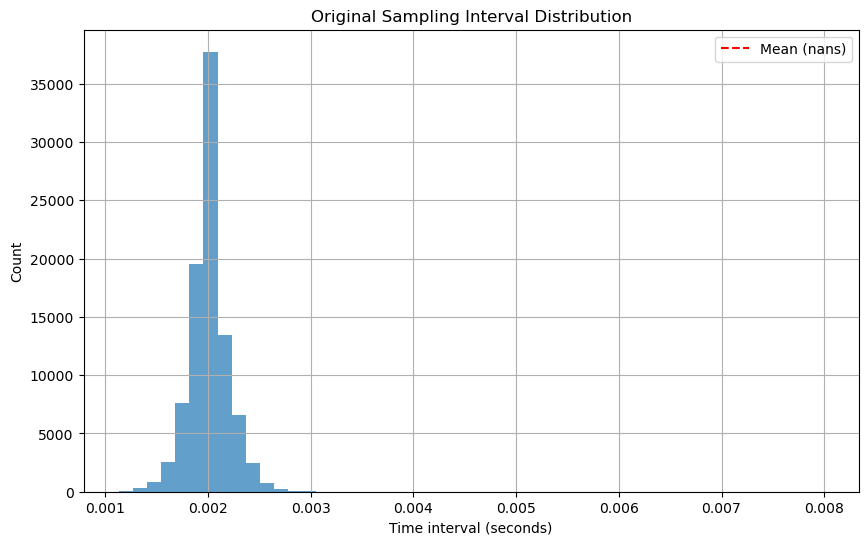

In [165]:
# # signal analysis for time diff sampling, to see if there is any outliers
# 
raw_dt = dataset_500.get_df()["time"].diff().values
plt.figure(figsize=(10, 6))
plt.hist(raw_dt, bins=50, alpha=0.7)
plt.axvline(np.mean(raw_dt), color='r', linestyle='--', label=f'Mean ({np.mean(raw_dt):.4f}s)')
plt.title('Original Sampling Interval Distribution')
plt.xlabel('Time interval (seconds)')
plt.ylabel('Count')
plt.grid(True)
plt.legend()
plt.show()


Target_position Analysis:
Range: [-8.898, 8.900]
Mean ± Std: 0.026 ± 3.631
Outliers: 0 (0.00%)
Outlier range: [-9.069, 9.138]

Position Analysis:
Range: [-6.781, 7.143]
Mean ± Std: 0.008 ± 1.039
Outliers: 2030 (11.00%)
Outlier range: [-1.336, 1.252]

Velocity Analysis:
Range: [-51.296, 51.278]
Mean ± Std: 0.025 ± 15.464
Outliers: 1278 (6.92%)
Outlier range: [-29.963, 29.849]

Torque Analysis:
Range: [-0.382, 0.388]
Mean ± Std: 0.002 ± 0.276
Outliers: 0 (0.00%)
Outlier range: [-1.283, 1.284]


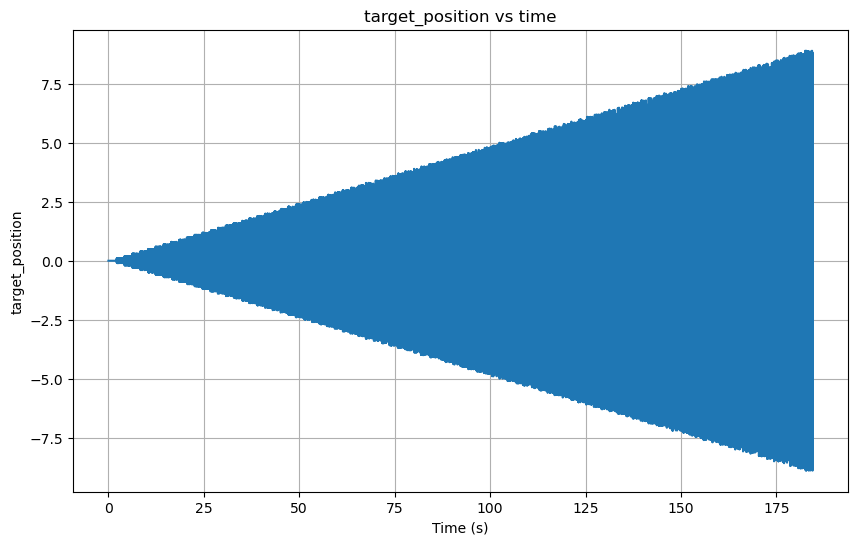

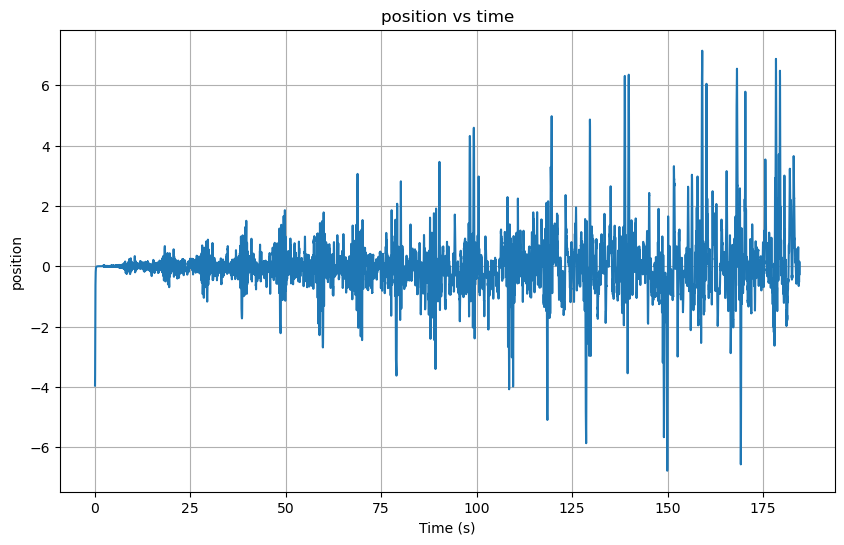

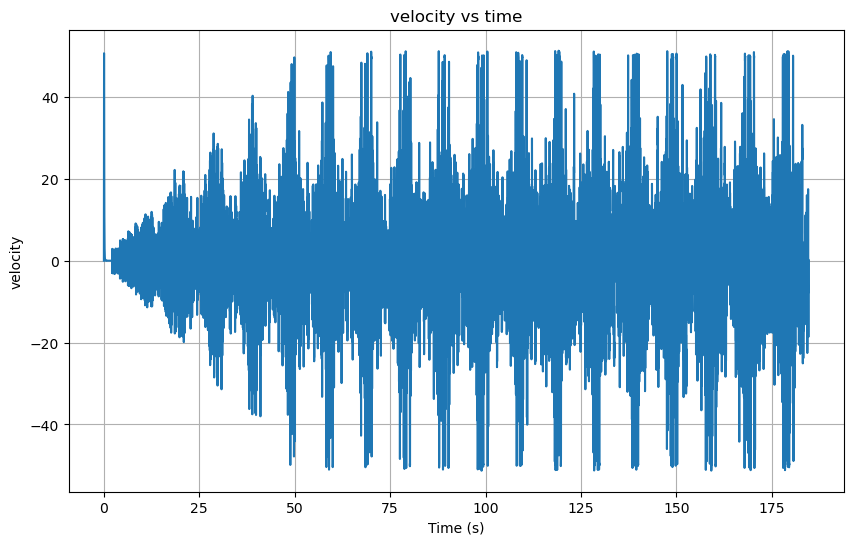

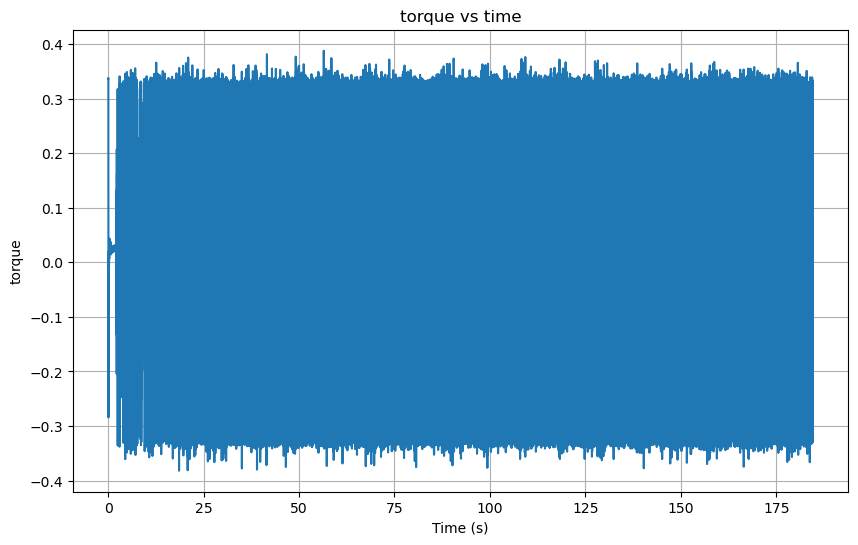

In [166]:
# perfom signal analysis to make sure there is not outliers
signals = ["target_position","position", "velocity", "torque"]

for signal in signals:
    data = dataset_100.get_df()[signal]
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    print(f"\n{signal.capitalize()} Analysis:")
    print(f"Range: [{data.min():.3f}, {data.max():.3f}]")
    print(f"Mean ± Std: {data.mean():.3f} ± {data.std():.3f}")
    print(f"Outliers: {len(outliers)} ({(len(outliers)/len(data))*100:.2f}%)")
    print(f"Outlier range: [{lower_bound:.3f}, {upper_bound:.3f}]")
for signal in signals:
    plt.figure(figsize=(10, 6))
    plt.plot(dataset_100.get_df()["time"], dataset_100.get_df()[signal])
    plt.title(f"{signal} vs time")
    plt.xlabel("Time (s)")
    plt.ylabel(signal)
    plt.grid(True)
    plt.show()


Target_position Analysis:
Range: [-8.898, 8.900]
Mean ± Std: 0.028 ± 3.629
Outliers: 0 (0.00%)
Outlier range: [-9.049, 9.127]

Position Analysis:
Range: [-6.787, 7.146]
Mean ± Std: 0.009 ± 1.039
Outliers: 10159 (11.01%)
Outlier range: [-1.336, 1.253]

Velocity Analysis:
Range: [-51.339, 51.307]
Mean ± Std: 0.021 ± 15.466
Outliers: 6352 (6.88%)
Outlier range: [-30.020, 29.915]

Torque Analysis:
Range: [-0.395, 0.394]
Mean ± Std: 0.002 ± 0.275
Outliers: 0 (0.00%)
Outlier range: [-1.283, 1.283]


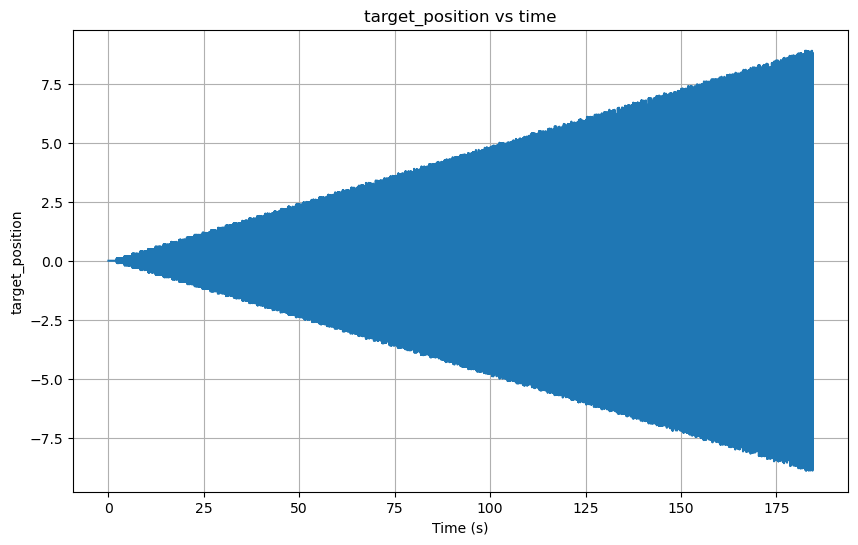

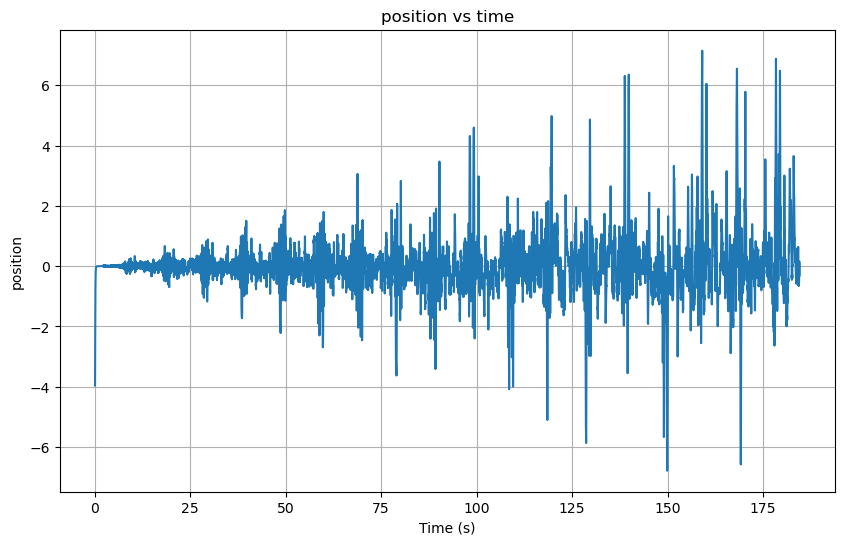

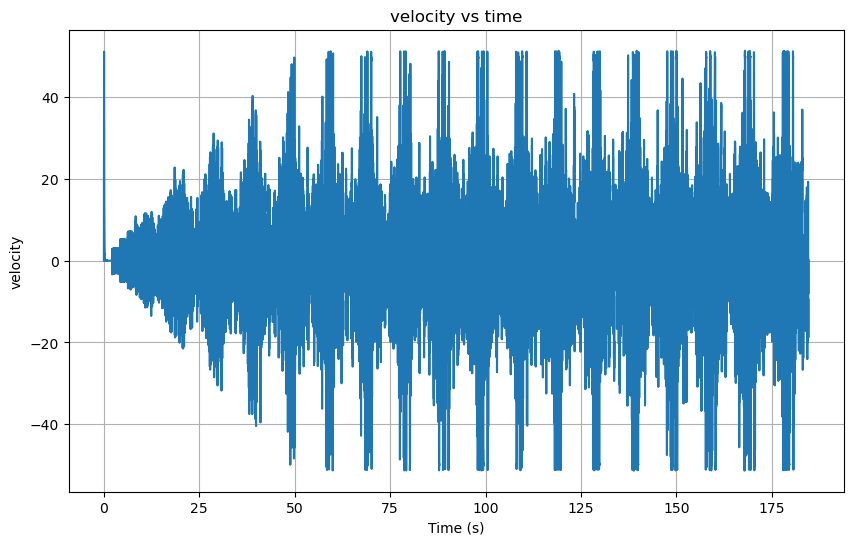

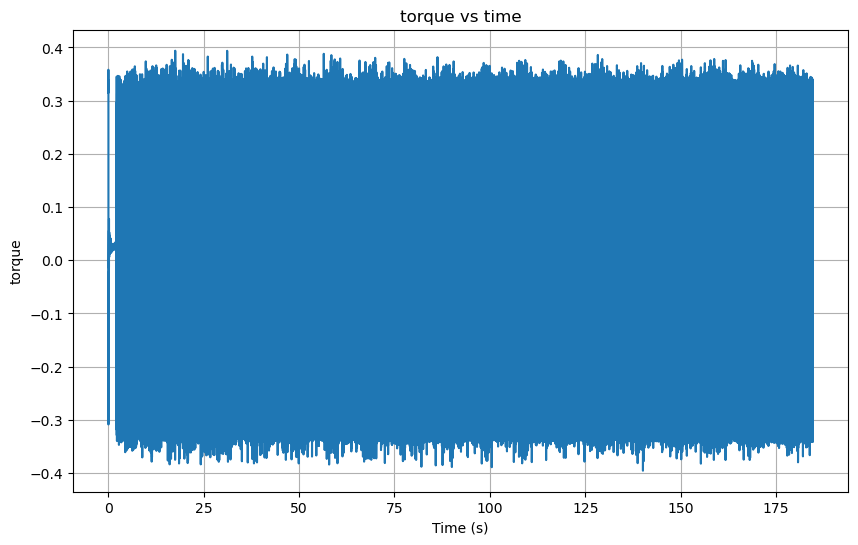

In [167]:
# perfom signal analysis to make sure there is not outliers
signals = ["target_position","position", "velocity", "torque"]

for signal in signals:
    data = dataset_500.get_df()[signal]
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    print(f"\n{signal.capitalize()} Analysis:")
    print(f"Range: [{data.min():.3f}, {data.max():.3f}]")
    print(f"Mean ± Std: {data.mean():.3f} ± {data.std():.3f}")
    print(f"Outliers: {len(outliers)} ({(len(outliers)/len(data))*100:.2f}%)")
    print(f"Outlier range: [{lower_bound:.3f}, {upper_bound:.3f}]")
for signal in signals:
    plt.figure(figsize=(10, 6))
    plt.plot(dataset_500.get_df()["time"], dataset_500.get_df()[signal])
    plt.title(f"{signal} vs time")
    plt.xlabel("Time (s)")
    plt.ylabel(signal)
    plt.grid(True)
    plt.show()

In [168]:
features_100, targets_100, time_100 = dataset_100.preprocess_data()
dataset_100.save_prepocessed_data("dataset_100_processed_data.csv")
features_500, targets_500, time_500 = dataset_500.preprocess_data()
dataset_500.save_prepocessed_data("dataset_500_processed_data.csv")

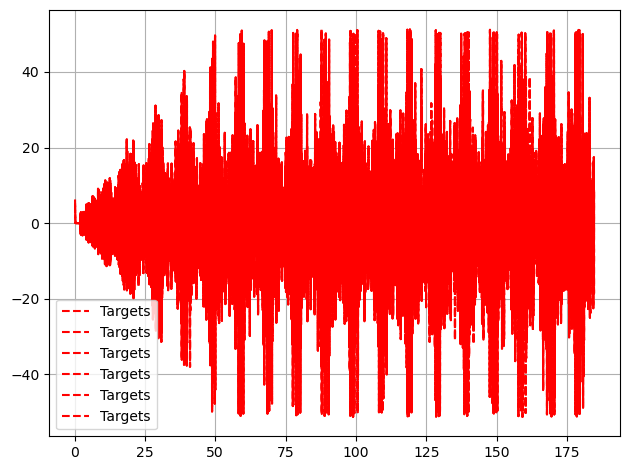

In [169]:
# Position plot
plt.plot(time_100,features_100, 'r--', label='Targets')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

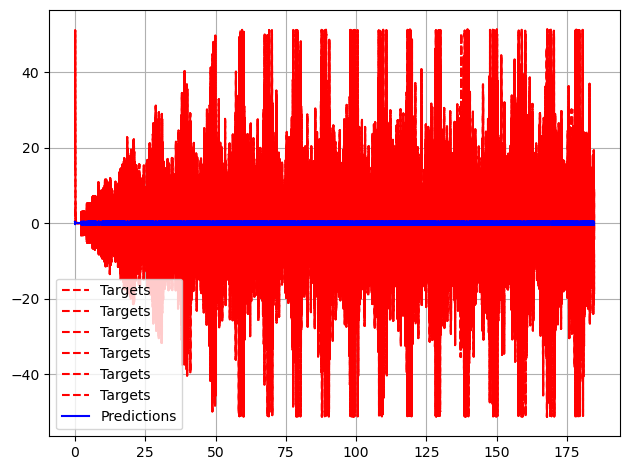

In [170]:
plt.plot(time_500,features_500, 'r--', label='Targets')
plt.plot(time_500, targets_500, 'b-', label='Predictions')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [171]:
# get normalize data
norm_features_100, norm_targets_100, norm_time_100 = dataset_100.normalize_data()
norm_features_500, norm_targets_500, norm_time_500 = dataset_500.normalize_data()
print(norm_features_100)

Features shape: (18436, 6), Targets shape: (18436,)
Features shape: (92273, 6), Targets shape: (92273,)
[[ 0.05738001  0.07040991  0.0827883   0.29986515  0.33867185  0.40484411]
 [ 0.04720335  0.05738001  0.07040991  0.24142338  0.29986515  0.33867185]
 [ 0.03851527  0.04720335  0.05738001  0.17408902  0.24142338  0.29986515]
 ...
 [-1.02961465 -1.15305642  2.33908045 -0.65048695  0.01872397 -0.50790933]
 [ 2.38948655 -1.02961465 -1.15305642 -1.20582781 -0.65048695  0.01872397]
 [-1.17659743  2.38948655 -1.02961465 -0.43928906 -1.20582781 -0.65048695]]


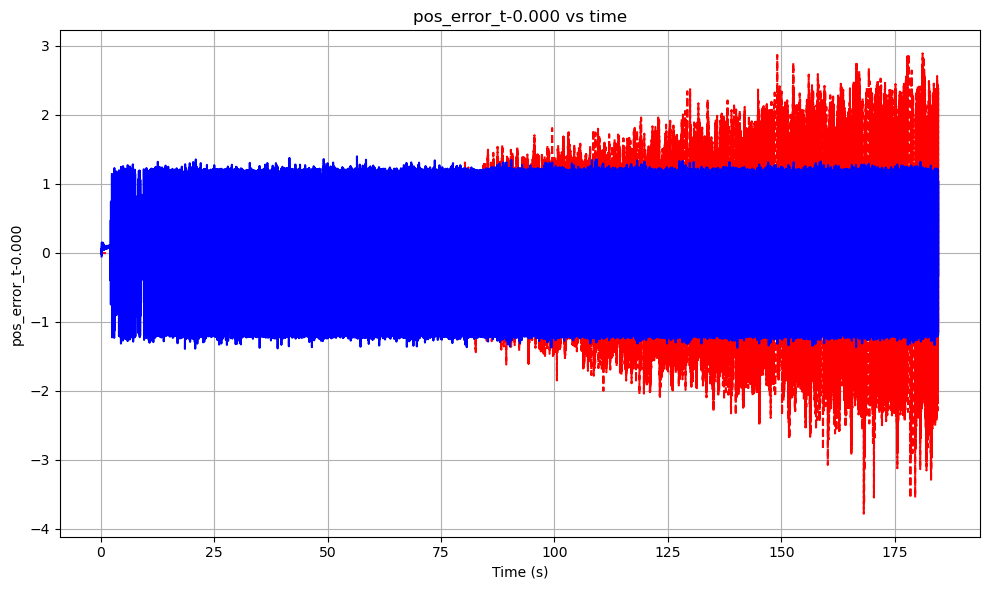

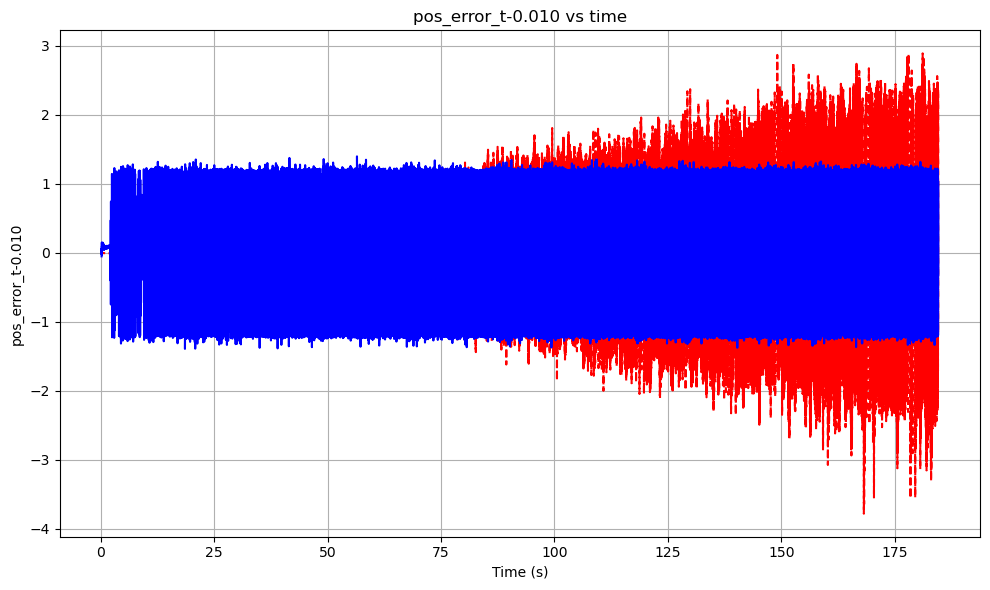

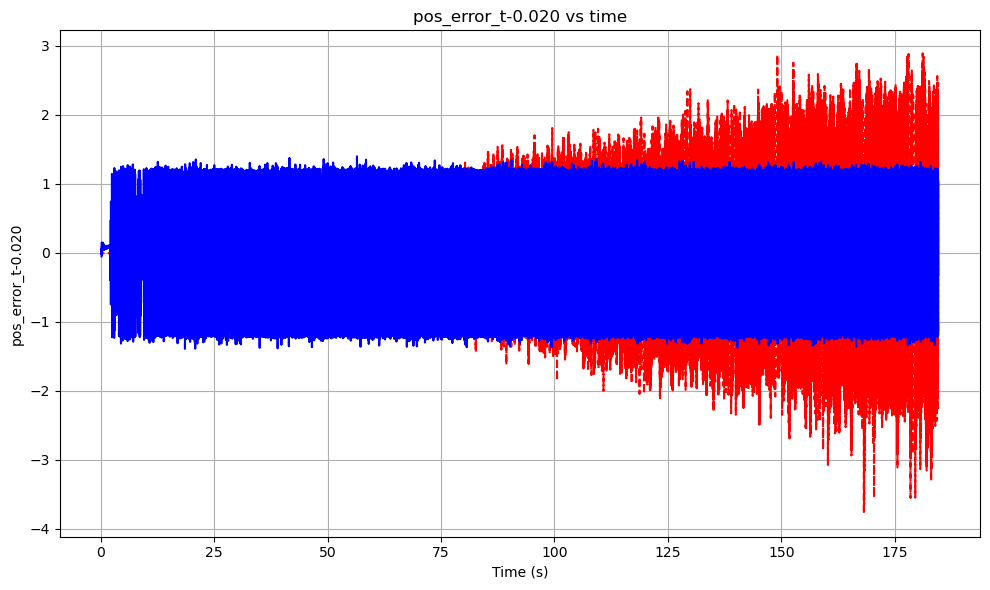

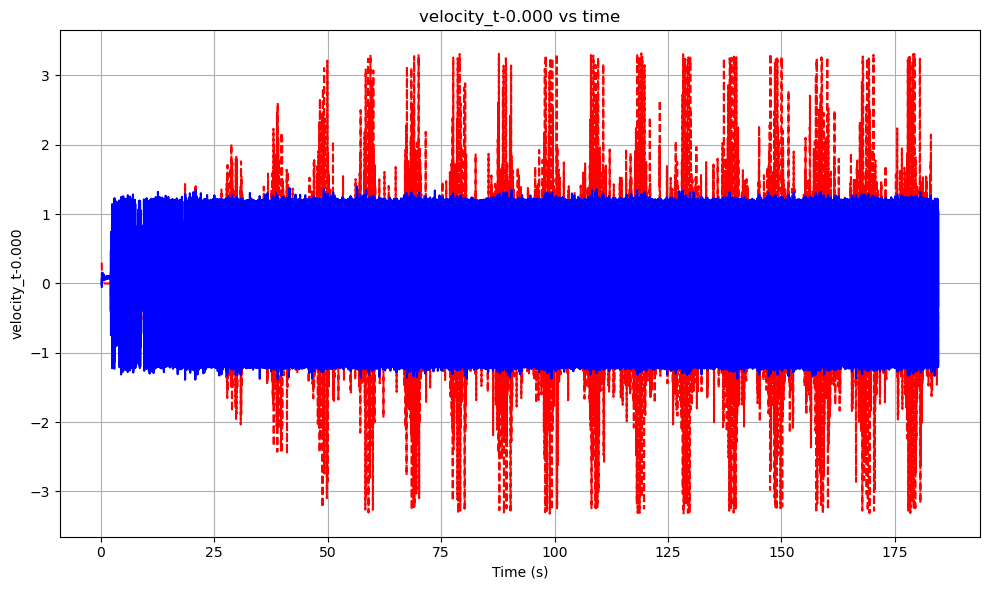

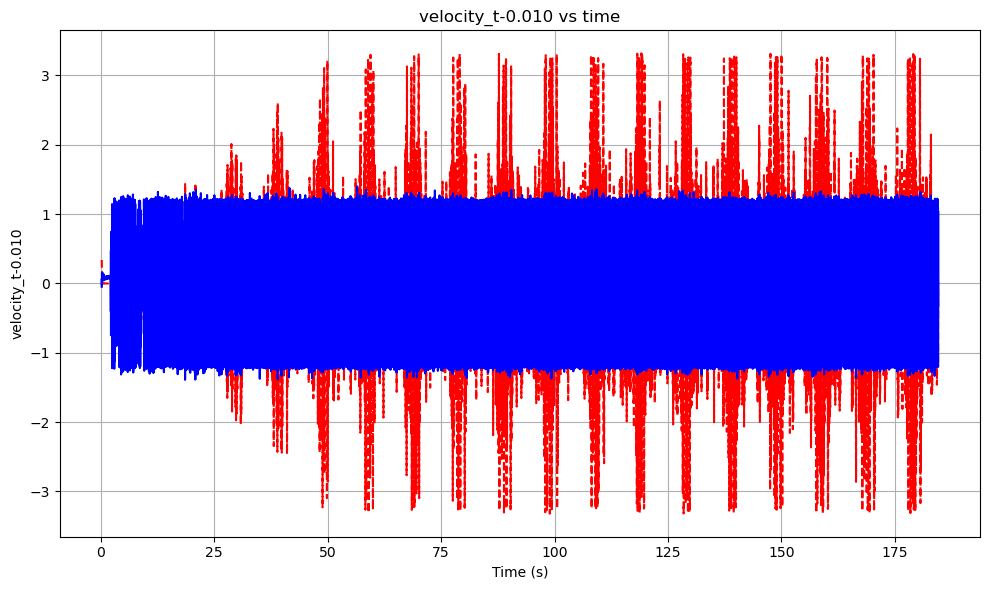

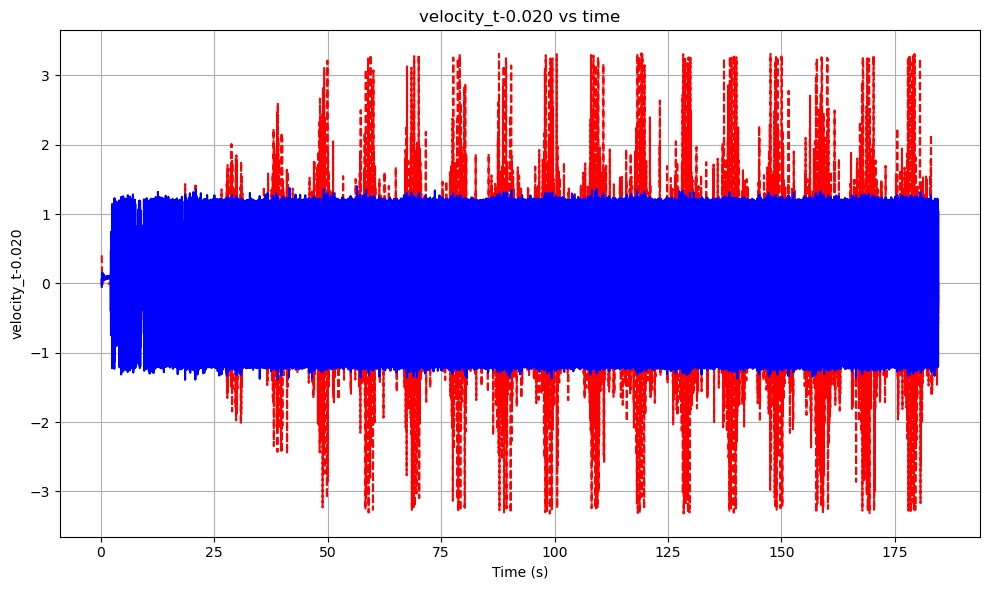

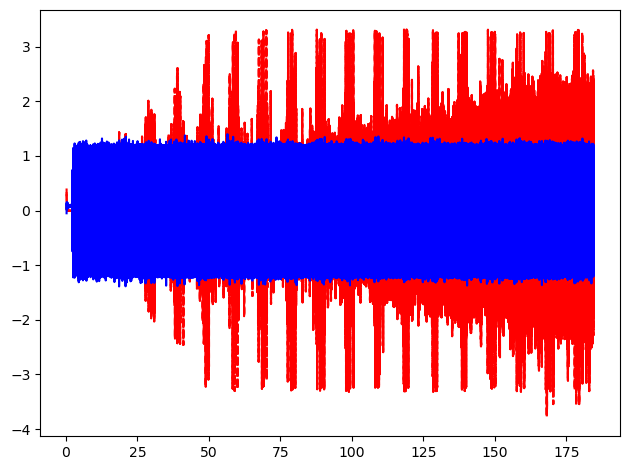

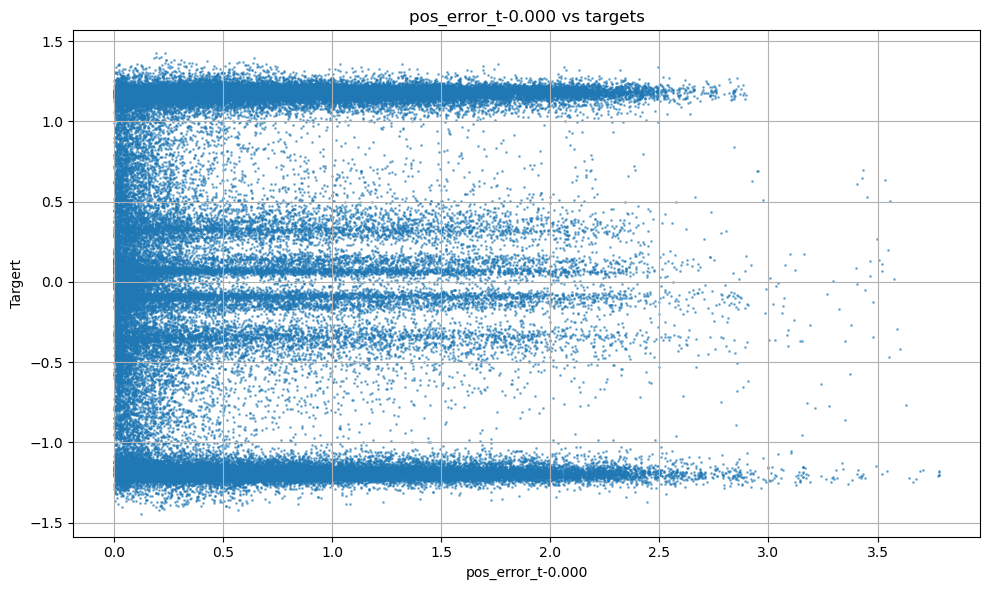

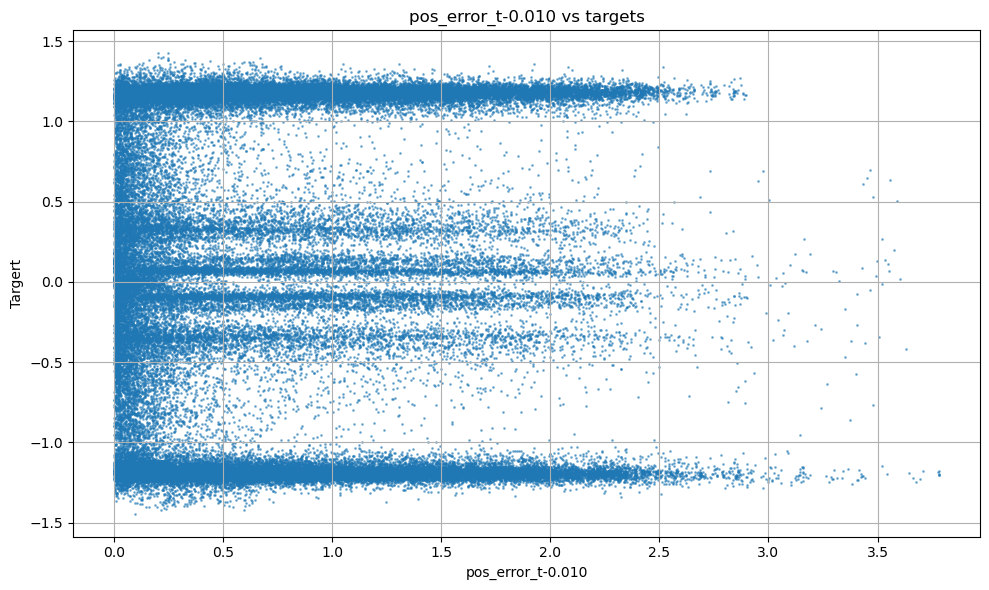

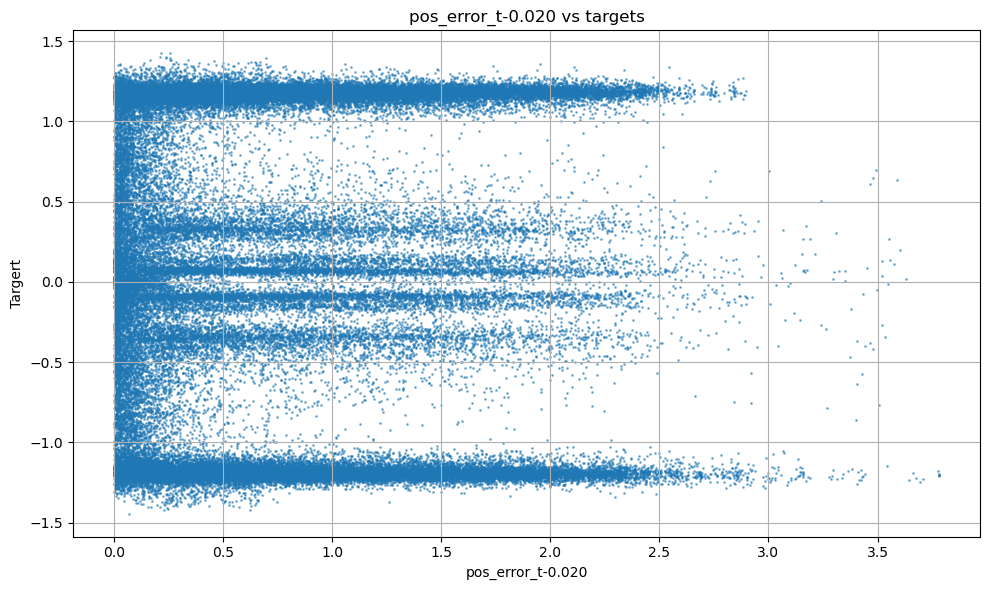

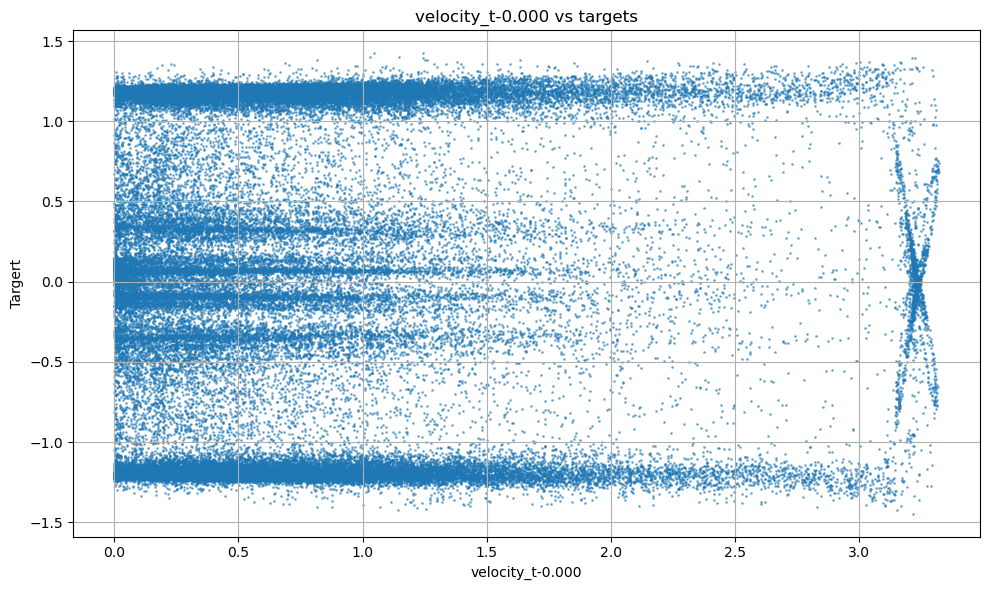

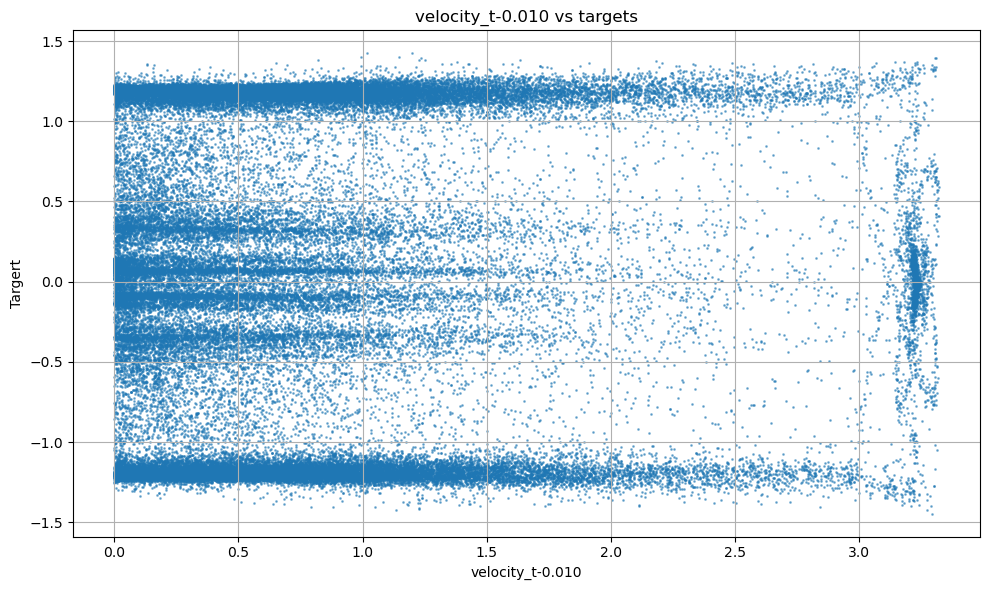

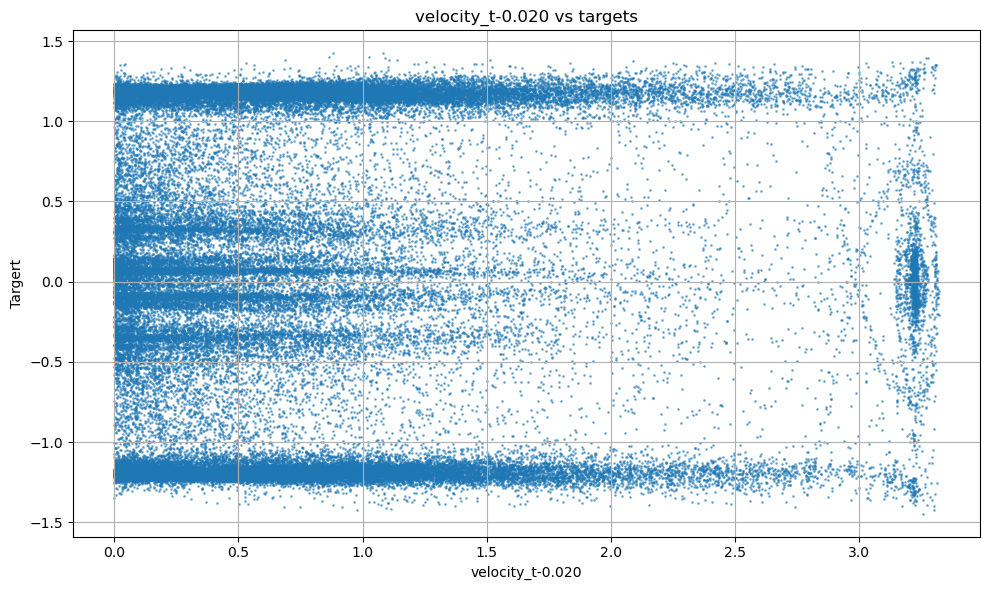

In [172]:
# plot the normalized data
signals = ["pos_error_t-0.000", "pos_error_t-0.010", "pos_error_t-0.020","velocity_t-0.000","velocity_t-0.010" ,"velocity_t-0.020","torque"]

for i in range(len(signals) - 1):
    plt.figure(figsize=(10, 6))
    plt.plot(norm_time_100, norm_features_100[:, i], 'r--', label='Targets')
    plt.plot(norm_time_100, norm_targets_100, 'b-', label='Predictions')
    plt.title(f"{signals[i]} vs time")
    plt.xlabel("Time (s)")
    plt.ylabel(signals[i])
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plt.plot(norm_time_100, norm_features_100, 'r--', label='Targets')
plt.plot(norm_time_100, norm_targets_100, 'b-', label='Predictions')
plt.tight_layout()
plt.show()
for i in range(len(signals) - 1):
    plt.figure(figsize=(10, 6))
    plt.scatter( np.absolute(norm_features_500[:,i]),norm_targets_500,alpha=0.5, s=1)
    plt.title(f"{signals[i]} vs targets")
    plt.ylabel("Targert")
    plt.xlabel(signals[i])
    plt.grid(True)
    plt.tight_layout()
    plt.show()

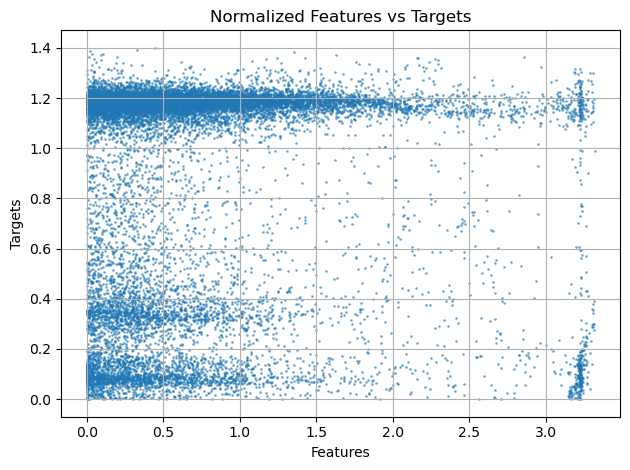

In [173]:
plt.scatter(np.abs(norm_features_100[:, 5]), np.abs(norm_targets_100), alpha=0.5, s=1)
plt.xlabel('Features')
plt.ylabel('Targets')
plt.title('Normalized Features vs Targets')
plt.grid(True)
plt.tight_layout()
plt.show()


In [174]:
from typing import Tuple, Dict
class ActuatorNet(nn.Module):
    def __init__(self, input_size: int = 6, hidden_size: int = 32, num_layers: int = 3):
        super().__init__()
        # input layer
        layers = [
            nn.Linear(input_size, hidden_size),
            nn.Softsign()
        ]

        # hidden layers
        for _ in range(num_layers - 2):
            layers.extend([
                nn.Linear(hidden_size, hidden_size),
                nn.Softsign()
            ])
            layers.append(nn.Linear(hidden_size, 1))

        self.network = nn.Sequential(*layers)
        self.initialize_weights()

    def initialize_weights(self) -> None:
        """Initialize weights"""
        for layer in self.network:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass"""
        return self.network(x)

    def predict(self, pos_error: torch.Tensor, vel_error: torch.Tensor) -> torch.Tensor:
        """Convenience method to predict"""
        x = torch.cat([pos_error, vel_error], dim=1)
        return self.forward(x)

In [202]:
def plot_training_history(history: Dict, save_path: str = None):
    """Plot training history"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

    # Plot losses
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot learning rate
    ax2.plot(history['learning_rates'])
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Learning Rate')
    ax2.set_title('Learning Rate Schedule')
    ax2.grid(True)
    ax2.set_yscale('log')

    plt.tight_layout()

    # if save_path:
    #     plt.savefig(save_path)
    plt.show()


class ActuatorTrainer:
    """Handles training of the actuator model"""

    def __init__(self, model: ActuatorNet, device: str = 'cuda' if torch.cuda.is_available() else 'cpu'):
        """
        Args:
            model: ActuatorNet instance
            device: Device to train on
        """
        self.model = model
        self.device = device

    def compute_metrics(self, loader: DataLoader) -> Dict[str, float]:
        """Compute detailed metrics on given data loader"""
        self.model.eval()
        all_targets = []
        all_predictions = []

        with torch.no_grad():
            for features, targets in loader:
                features = features.to(self.device).float()
                targets = targets.to(self.device).float()

                outputs = self.model(features)

                all_targets.extend(targets.cpu().numpy())
                all_predictions.extend(outputs.squeeze(1).cpu().numpy())

        all_targets = np.array(all_targets)
        all_predictions = np.array(all_predictions)

        return {
            'mse': mean_squared_error(all_targets, all_predictions),
            'rmse': np.sqrt(mean_squared_error(all_targets, all_predictions)),
            'mae': mean_absolute_error(all_targets, all_predictions),
            'r2': r2_score(all_targets, all_predictions)
        }

    def plot_prediction_vs_actual(self, loader: DataLoader, save_path: str = None):
        """Plot prediction vs actual values"""
        self.model.eval()
        all_targets = []
        all_predictions = []

        with torch.no_grad():
            for features, targets in loader:
                features = features.to(self.device).float()
                targets = targets.to(self.device).float()

                outputs = self.model(features)

                all_targets.extend(targets.cpu().numpy())
                all_predictions.extend(outputs.squeeze(1).cpu().numpy())

        plt.figure(figsize=(10, 10))
        plt.scatter(all_targets, all_predictions, alpha=0.5)
        plt.plot([-2, 2], [-2, 2], 'r--')  # Perfect prediction line
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title('Prediction vs Actual')
        plt.grid(True)

        if save_path:
            plt.savefig(save_path)
        plt.show()

    def train(self,
              train_loader: DataLoader,
              val_loader: DataLoader,
              epochs: int = 100,
              lr: float = 1e-3,
              patience: int = 10) -> Dict:
        """Train the actuator model

        Args:
            train_loader: Training data loader
            val_loader: Validation data loader
            epochs: Number of epochs to train
            lr: Initial learning rate
            patience: Number of epochs to wait for improvement before early stopping

        Returns:
            Dict containing training history
        """
        self.model = self.model.to(self.device)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

        # Initialize tracking variables
        best_val_loss = float('inf')
        patience_counter = 0
        history = {
            'train_loss': [],
            'val_loss': [],
            'learning_rates': []
        }
        best_model_state = None

        for epoch in range(epochs):
            # Training phase
            self.model.train()
            train_losses = []

            for features, targets in train_loader:
                features = features.to(self.device).float()
                targets = targets.to(self.device).float()

                # Forward pass
                outputs = self.model(features)
                loss = criterion(outputs, targets.unsqueeze(1))

                # Backward pass and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                train_losses.append(loss.item())

            # Validation phase
            self.model.eval()
            val_losses = []

            with torch.no_grad():
                for features, targets in val_loader:
                    features = features.to(self.device).float()
                    targets = targets.to(self.device).float()

                    outputs = self.model(features)
                    val_loss = criterion(outputs, targets.unsqueeze(1))
                    val_losses.append(val_loss.item())

            # Calculate average losses
            avg_train_loss = np.mean(train_losses)
            avg_val_loss = np.mean(val_losses)
            current_lr = optimizer.param_groups[0]['lr']

            
            history['train_loss'].append(avg_train_loss)
            history['val_loss'].append(avg_val_loss)
            history['learning_rates'].append(current_lr)

            # Print progress
            print(
                f'Epoch [{epoch + 1}/{epochs}] Train Loss: {avg_train_loss:.4f} Val Loss: {avg_val_loss:.4f} LR: {current_lr:.6f}')

            # Learning rate scheduling
            scheduler.step(avg_val_loss)

            # Early stopping check
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                patience_counter = 0
                best_model_state = self.model.state_dict().copy()
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch + 1} epochs')
                break

        # Restore best model
        if best_model_state is not None:
            self.model.load_state_dict(best_model_state)

        return history

    def get_model(self) -> ActuatorNet:
        return self.model
    
    def save_model(self, path: str, scaler_params: Dict) -> None:
        """Save model and scaling parameters

        Args:
            path: Path to save the model (without extension)
            scaler_params: Dictionary containing normalization parameters
        """
        # Save model state
        # torch.save({
        #     'model_state_dict': self.model.state_dict(),
        #     'scaler_params': scaler_params,
        #     'input_size': self.model.network[0].in_features,
        #     'hidden_size': self.model.network[0].out_features,
        #     'num_layers': len([layer for layer in self.model.network if isinstance(layer, nn.Linear)])
        # }, f"{path}.pth")
        torch.save(self.model.state_dict(), path)

        # Save normalization parameters separately for easier access
        import json
        with open(f"{path}_scaler.json", 'w') as f:
            json.dump(scaler_params, f, indent=4)

    def load_model(self, path: str) -> Tuple[Dict, Dict]:
        checkpoint = torch.load(f"{path}.pt")
        # Reconstruct model architecture
        self.model = ActuatorNet(
            input_size=checkpoint['input_size'],
            hidden_size=checkpoint['hidden_size'],
            num_layers=checkpoint['num_layers']
        )

        # Load model weights
        self.model.load_state_dict(checkpoint['model_state_dict'])

        return checkpoint['model_state_dict'], checkpoint['scaler_params']
    
    def denormalize_and_compare(self, loader: DataLoader, dataset: ActuatorDataset, base_save_path: str = "comparison"):
        """
        Denormalize predictions and actual values, save to CSV and create separate plots
        """
        self.model.eval()
        results = {
            'position_error': [],
            'velocity': [],
            'actual_torque': [],
            'predicted_torque': []
        }

        with torch.no_grad():
            for features, targets in loader:
                features = features.to(self.device).float()
                outputs = self.model(features)

                # Denormalize predictions and targets
                pred_denorm = (outputs.squeeze().cpu().numpy() * dataset.scaler_params['torque_std'] +
                               dataset.scaler_params['torque_mean'])
                target_denorm = (targets.cpu().numpy() * dataset.scaler_params['torque_std'] +
                                 dataset.scaler_params['torque_mean'])

                # Denormalize position error and velocity (taking just current timestep)
                pos_error_denorm = (features[:, 0].cpu().numpy() * dataset.scaler_params['pos_error_std'] +
                                    dataset.scaler_params['pos_error_mean'])
                vel_denorm = (features[:, 3].cpu().numpy() * dataset.scaler_params['vel_std'] +
                              dataset.scaler_params['vel_mean'])

                # Collect results
                results['position_error'].extend(pos_error_denorm)
                results['velocity'].extend(vel_denorm)
                results['actual_torque'].extend(target_denorm)
                results['predicted_torque'].extend(pred_denorm)

        # Save to CSV
        df = pd.DataFrame(results)
        df.to_csv(f"{base_save_path}.csv", index=False)

        # Save denormalization factors
        with open(f"{base_save_path}_denorm_factors.txt", 'w') as f:
            f.write("Denormalization Factors:\n")
            for key, value in dataset.scaler_params.items():
                f.write(f"{key}: {value}\n")

        # Create separate plots with plt.figure()

        # 1. Actual vs Predicted Torque
        plt.figure(figsize=(10, 8))
        plt.scatter(results['actual_torque'], results['predicted_torque'], alpha=0.5, s=1)
        min_val = min(min(results['actual_torque']), min(results['predicted_torque']))
        max_val = max(max(results['actual_torque']), max(results['predicted_torque']))
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')
        plt.xlabel('Actual Torque (Nm)')
        plt.ylabel('Predicted Torque (Nm)')
        plt.title('Predicted vs Actual Torque')
        plt.legend()
        plt.grid(True)
        plt.savefig(f"{base_save_path}_actual_vs_predicted.png", dpi=300)
        plt.show()

        # 2. Actual Torque vs Position Error
        plt.figure(figsize=(10, 8))
        plt.scatter(results['position_error'], results['actual_torque'], alpha=0.5, s=1, label='Actual')
        plt.xlabel('Position Error (rad)')
        plt.ylabel('Torque (Nm)')
        plt.title('Actual Torque vs Position Error')
        plt.grid(True)
        plt.legend()
        plt.savefig(f"{base_save_path}_actual_vs_position.png", dpi=300)
        plt.show()

        # 3. Predicted Torque vs Position Error
        plt.figure(figsize=(10, 8))
        plt.scatter(results['position_error'], results['predicted_torque'], alpha=0.5, s=1, label='Predicted')
        plt.xlabel('Position Error (rad)')
        plt.ylabel('Torque (Nm)')
        plt.title('Predicted Torque vs Position Error')
        plt.grid(True)
        plt.legend()
        plt.savefig(f"{base_save_path}_predicted_vs_position.png", dpi=300)
        plt.show()

        # 4. Actual Torque vs Velocity
        plt.figure(figsize=(10, 8))
        plt.scatter(results['velocity'], results['actual_torque'], alpha=0.5, s=1, label='Actual')
        plt.xlabel('Velocity (rad/s)')
        plt.ylabel('Torque (Nm)')
        plt.title('Actual Torque vs Velocity')
        plt.grid(True)
        plt.legend()
        plt.savefig(f"{base_save_path}_actual_vs_velocity.png", dpi=300)
        plt.show()

        # 5. Predicted Torque vs Velocity
        plt.figure(figsize=(10, 8))
        plt.scatter(results['velocity'], results['predicted_torque'], alpha=0.5, s=1, label='Predicted')
        plt.xlabel('Velocity (rad/s)')
        plt.ylabel('Torque (Nm)')
        plt.title('Predicted Torque vs Velocity')
        plt.grid(True)
        plt.legend()
        plt.savefig(f"{base_save_path}_predicted_vs_velocity.png", dpi=300)
        plt.show()

        # 6. Time series comparison
        plt.figure(figsize=(10, 8))
        samples = range(200)  # First 200 samples
        plt.plot(samples, results['actual_torque'][:200], label='Actual')
        plt.plot(samples, results['predicted_torque'][:200], label='Predicted')
        plt.xlabel('Sample')
        plt.ylabel('Torque (Nm)')
        plt.title('Torque Time Series Comparison')
        plt.legend()
        plt.grid(True)
        plt.savefig(f"{base_save_path}_time_series.png", dpi=300)
        plt.show()

        # Print denormalized statistics
        error = np.array(results['actual_torque']) - np.array(results['predicted_torque'])
        print("\nDenormalized Metrics:")
        print(f"Mean Error: {np.mean(error):.4f} Nm")
        print(f"RMSE: {np.sqrt(np.mean(error ** 2)):.4f} Nm")
        print(f"MAE: {np.mean(np.abs(error)):.4f} Nm")
        print(f"Max Error: {np.max(np.abs(error)):.4f} Nm")
        print(f"R²: {r2_score(results['actual_torque'], results['predicted_torque']):.4f}")

        # Additional statistics
        print("\nValue Ranges:")
        print(f"Position Error: [{min(results['position_error']):.4f}, {max(results['position_error']):.4f}] rad")
        print(f"Velocity: [{min(results['velocity']):.4f}, {max(results['velocity']):.4f}] rad/s")
        print(f"Actual Torque: [{min(results['actual_torque']):.4f}, {max(results['actual_torque']):.4f}] Nm")
        print(f"Predicted Torque: [{min(results['predicted_torque']):.4f}, {max(results['predicted_torque']):.4f}] Nm")

In [203]:
# split the data 
X_train_100, X_temp_100, y_train_100, y_temp_100 = train_test_split(
    norm_features_100, norm_targets_100, train_size=0.8, random_state=42
)

X_val_100, X_test_100, y_val_100, y_test_100 = train_test_split(
    X_temp_100, y_temp_100, test_size=0.5, random_state=42
)

X_train_500, X_temp_500, y_train_500, y_temp_500= train_test_split(
    norm_features_500, norm_targets_500, train_size=0.8, random_state=42
)

X_val_500, X_test_500, y_val_500, y_test_500 = train_test_split(
    X_temp_500, y_temp_500, test_size=0.5, random_state=42
)

# Create TensorDatasets
train_dataset_100 = TensorDataset(torch.FloatTensor(X_train_100), torch.FloatTensor(y_train_100))
val_dataset_100 = TensorDataset(torch.FloatTensor(X_val_100), torch.FloatTensor(y_val_100))
test_dataset_100 = TensorDataset(torch.FloatTensor(X_test_100), torch.FloatTensor(y_test_100))

train_dataset_500 = TensorDataset(torch.FloatTensor(X_train_500), torch.FloatTensor(y_train_500))
val_dataset_500 = TensorDataset(torch.FloatTensor(X_val_500), torch.FloatTensor(y_val_500))
test_dataset_500 = TensorDataset(torch.FloatTensor(X_test_500), torch.FloatTensor(y_test_500))

# Create DataLoaders
batch_size = 32
train_loader_100 = DataLoader(train_dataset_100, batch_size=batch_size, shuffle=True)
val_loader_100 = DataLoader(val_dataset_100, batch_size=batch_size)
test_loader_100 = DataLoader(test_dataset_100, batch_size=batch_size)

train_loader_500 = DataLoader(train_dataset_500, batch_size=batch_size, shuffle=True)
val_loader_500 = DataLoader(val_dataset_500, batch_size=batch_size)
test_loader_500 = DataLoader(test_dataset_500, batch_size=batch_size)


100Hz Dataset splits:
Training samples: 14748 (80.0%)
Validation samples: 1844 (10.0%)
Test samples: 1844 (10.0%)

500Hz Dataset splits:
Training samples: 73818 (80.0%)
Validation samples: 9227 (10.0%)
Test samples: 9228 (10.0%)


In [204]:
actuator_model_100 = ActuatorNet()
actuator_model_500 = ActuatorNet()
trainer_100 = ActuatorTrainer(actuator_model_100)
trainer_500 = ActuatorTrainer(actuator_model_500)

history_100 = trainer_100.train(train_loader_100, val_loader_100, epochs=100, lr=1e-3, patience=10)
history_500 = trainer_500.train(train_loader_500, val_loader_500, epochs=100, lr=1e-3, patience=10)


Epoch [1/100] Train Loss: 0.3409 Val Loss: 0.2693 LR: 0.001000
Epoch [2/100] Train Loss: 0.2239 Val Loss: 0.2004 LR: 0.001000
Epoch [3/100] Train Loss: 0.1794 Val Loss: 0.1715 LR: 0.001000
Epoch [4/100] Train Loss: 0.1556 Val Loss: 0.1506 LR: 0.001000
Epoch [5/100] Train Loss: 0.1370 Val Loss: 0.1292 LR: 0.001000
Epoch [6/100] Train Loss: 0.1232 Val Loss: 0.1183 LR: 0.001000
Epoch [7/100] Train Loss: 0.1139 Val Loss: 0.1116 LR: 0.001000
Epoch [8/100] Train Loss: 0.1072 Val Loss: 0.1041 LR: 0.001000
Epoch [9/100] Train Loss: 0.1023 Val Loss: 0.1009 LR: 0.001000
Epoch [10/100] Train Loss: 0.0987 Val Loss: 0.0977 LR: 0.001000
Epoch [11/100] Train Loss: 0.0954 Val Loss: 0.0988 LR: 0.001000
Epoch [12/100] Train Loss: 0.0924 Val Loss: 0.0906 LR: 0.001000
Epoch [13/100] Train Loss: 0.0901 Val Loss: 0.0906 LR: 0.001000
Epoch [14/100] Train Loss: 0.0874 Val Loss: 0.0870 LR: 0.001000
Epoch [15/100] Train Loss: 0.0856 Val Loss: 0.0910 LR: 0.001000
Epoch [16/100] Train Loss: 0.0841 Val Loss: 0.085

In [210]:
def denormalize(set: np.array, mean: float, std:float) -> np.array:
    """Denormalize a dataset"""
    return set * std + mean
def normalize(set: np.array, mean: float, std: float) -> np.array:
    """Normalize a dataset"""
    return (set - mean) / std


In [212]:
# Denormalize and compare
def evaluate_model(model, test_loader, dataset, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.eval()
    res_targets = []
    res_predictions = []
    res_pos_errors = []
    res_velocities = []
    
    with torch.no_grad():
        for features, targets in test_loader:
            features = features.to(device).float()
            targets = targets.to(device).float()
            
            outputs = model(features)
            
            # Store normalized values
            res_targets.extend(targets.cpu().numpy())
            res_predictions.extend(outputs.squeeze().cpu().numpy())
            
            # Store position errors and velocities for analysis
            pos_errors = features[:, 0].cpu().numpy()  # First feature is current position error
            velocities = features[:, 3].cpu().numpy()  # Fourth feature is current velocity
            res_pos_errors.extend(pos_errors)
            res_velocities.extend(velocities)
    
    # Convert to numpy arrays
    res_targets = np.array(res_targets)
    res_predictions = np.array(res_predictions)
    res_pos_errors = np.array(res_pos_errors)
    res_velocities = np.array(res_velocities)
    
    # Denormalize predictions and targets
    res_targets = denormalize(res_targets, dataset.scaler_params['torque_mean'], 
                            dataset.scaler_params['torque_std'])
    res_predictions = denormalize(res_predictions, dataset.scaler_params['torque_mean'], 
                                dataset.scaler_params['torque_std'])
    
    # Denormalize features
    res_pos_errors = denormalize(res_pos_errors, dataset.scaler_params['pos_error_mean'], 
                               dataset.scaler_params['pos_error_std'])
    res_velocities = denormalize(res_velocities, dataset.scaler_params['vel_mean'], 
                               dataset.scaler_params['vel_std'])
    
    # Calculate errors
    absolute_err = np.abs(res_targets - res_predictions)
    relative_err = np.abs(res_targets - res_predictions) / np.abs(res_targets)
    
    # Calculate metrics
    metrics = {
        'mse': mean_squared_error(res_targets, res_predictions),
        'rmse': np.sqrt(mean_squared_error(res_targets, res_predictions)),
        'mae': mean_absolute_error(res_targets, res_predictions),
        'r2': r2_score(res_targets, res_predictions),
        'max_abs_error': np.max(absolute_err),
        'mean_abs_error': np.mean(absolute_err),
        'median_abs_error': np.median(absolute_err),
        'max_rel_error': np.max(relative_err),
        'mean_rel_error': np.mean(relative_err),
        'median_rel_error': np.median(relative_err),
        'std_error': np.std(absolute_err)
    }
    # Print detailed metrics
    print("\nModel Performance Metrics:")
    print("-" * 50)
    print(f"MSE: {metrics['mse']:.4f} Nm²")
    print(f"RMSE: {metrics['rmse']:.4f} Nm")
    print(f"MAE: {metrics['mae']:.4f} Nm")
    print(f"R²: {metrics['r2']:.4f}")
    print("\nError Analysis:")
    print("-" * 50)
    print(f"Max Absolute Error: {metrics['max_abs_error']:.4f} Nm")
    print(f"Mean Absolute Error: {metrics['mean_abs_error']:.4f} Nm")
    print(f"Median Absolute Error: {metrics['median_abs_error']:.4f} Nm")
    print(f"Standard Deviation of Error: {metrics['std_error']:.4f} Nm")
    print(f"Max Relative Error: {metrics['max_rel_error']:.4%}")
    print(f"Mean Relative Error: {metrics['mean_rel_error']:.4%}")
    print(f"Median Relative Error: {metrics['median_rel_error']:.4%}")
    
    print("\nValue Ranges:")
    print("-" * 50)
    print(f"Target Torque Range: [{np.min(res_targets):.4f}, {np.max(res_targets):.4f}] Nm")
    print(f"Predicted Torque Range: [{np.min(res_predictions):.4f}, {np.max(res_predictions):.4f}] Nm")
    print(f"Position Error Range: [{np.min(res_pos_errors):.4f}, {np.max(res_pos_errors):.4f}] rad")
    print(f"Velocity Range: [{np.min(res_velocities):.4f}, {np.max(res_velocities):.4f}] rad/s")
    
    return metrics, (res_targets, res_predictions, res_pos_errors, res_velocities)

# Run evaluation

    

In [213]:
metrics_100, results_100 = evaluate_model(actuator_model_100, test_loader_100, dataset_100)


Model Performance Metrics:
--------------------------------------------------
MSE: 0.0047 Nm²
RMSE: 0.0685 Nm
MAE: 0.0427 Nm
R²: 0.9380

Error Analysis:
--------------------------------------------------
Max Absolute Error: 0.3407 Nm
Mean Absolute Error: 0.0427 Nm
Median Absolute Error: 0.0193 Nm
Standard Deviation of Error: 0.0536 Nm
Max Relative Error: 9384.2941%
Mean Relative Error: 92.5228%
Median Relative Error: 7.5927%

Value Ranges:
--------------------------------------------------
Target Torque Range: [-0.3686, 0.3771] Nm
Predicted Torque Range: [-0.3870, 0.3834] Nm
Position Error Range: [-13.1569, 10.7664] rad
Velocity Range: [-51.1420, 50.5761] rad/s


In [208]:
metrics_500, results_500 = evaluate_model(actuator_model_500, test_loader_500, dataset_500)


Model Performance Metrics:
--------------------------------------------------
MSE: 0.0004 Nm²
RMSE: 0.0207 Nm
MAE: 0.0113 Nm
R²: 0.9943

Error Analysis:
--------------------------------------------------
Max Absolute Error: 0.2497 Nm
Mean Absolute Error: 0.0113 Nm
Median Absolute Error: 0.0065 Nm
Standard Deviation of Error: 0.0173 Nm
Max Relative Error: 60555.4749%
Mean Relative Error: 45.3733%
Median Relative Error: 2.5275%

Value Ranges:
--------------------------------------------------
Target Torque Range: [-0.3848, 0.3754] Nm
Predicted Torque Range: [-0.3720, 0.3626] Nm
Position Error Range: [-14.0290, 10.7828] rad
Velocity Range: [-51.0898, 51.2779] rad/s


In [219]:
save_path = "../models/mlp_motor_model.pth"
trainer_500.save_model(save_path, dataset_500.scaler_params)

In [24]:
# new data frame
# import pandas as pd


df = pd.read_csv("../data/complete/data_2.csv")
df = df.reset_index()
# print(df.loc[df["target_position"].idxmax()])
# print("+++++++++++++++++++++++++++++++++\n")
# print(df.loc[df["target_position"].idxmin()])
# 
# print(df.loc[df["position"].idxmax()])
max_target = df["target_position"].idxmin()
row_loc = df.loc[max_target]
print(row_loc)
pos = np.sin(2 * np.pi * row_loc["frequency"] * row_loc["time"]) * row_loc["amplitude"]
print(f"Position: {pos:.4f}")
print(f"Pan: {row_loc['target_position']:.4f}")

index                     3194.000000
timestep                  3196.000000
time                         6.394481
target_position             -0.299951
position                    -0.029602
velocity                    -0.000050
torque                       0.001021
amplitude                    0.300000
frequency                    0.900000
1                                 NaN
0.017366409301757812              NaN
0.0                               NaN
-0.029602080583572388             NaN
-8.757004979997873e-05            NaN
-0.0024757548235356808            NaN
0.0.1                             NaN
0.0.2                             NaN
Name: 3194, dtype: float64
Position: -0.2999
Pan: -0.3000
